In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import subprocess
import sys
import io
import gradio as gr
import numpy as np
import random
import spaces
import torch
from diffusers import Flux2Pipeline, Flux2Transformer2DModel, FluxInpaintPipeline
from diffusers import BitsAndBytesConfig as DiffBitsAndBytesConfig
import requests
from PIL import Image
import json
import base64
from dotenv import load_dotenv
from huggingface_hub import login, InferenceClient
from helper_dev_utils import get_auto_logger
import sys
from pathlib import Path
import helper_plot_hangul
import importlib
import gc
import logging
import copy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from matplotlib.patches import Rectangle
from typing import List, Optional, Tuple, Dict, Any
from helper_plot_hangul import matplotlib_font_reset, matplotlib_font_get
from helper_dev_utils import *
from diffusers.utils import load_image
logger = get_auto_logger()

In [3]:
# Hugging Face 로그인 (FLUX 모델 접근 권한 필요)
load_dotenv()

# 환경 변수에서 토큰 가져오기 또는 직접 입력
hf_token = os.getenv("HF_TOKEN")
logger.info(f"Hugging Face Token: {hf_token[:2]} ... {hf_token[-2:]}")

if hf_token:
    login(token=hf_token)
    print("✓ Logged in with HF_TOKEN from environment")
else:
    # 수동 로그인 (토큰 입력 필요)
    login()
    print("✓ Manual login completed")

2026-01-16 13:13:11 I [ipykernel_launcher:6] - Hugging Face Token: hf ... LA


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


✓ Logged in with HF_TOKEN from environment


In [4]:
import sys
from pathlib import Path

# 프로젝트 경로 설정
project_root = Path.cwd().parent.parent / "src" / "nanoCocoa_aiserver"
sys.path.insert(0, str(project_root))
logger.debug(project_root)

import torch
import gc
from PIL import Image
from typing import Optional

from diffusers import DiffusionPipeline
from config import TORCH_DTYPE
from services.monitor import flush_gpu


2026-01-16 13:13:11 D [ipykernel_launcher:7] - /home/spai0433/codeit-ai-3team-ad-content/src/nanoCocoa_aiserver


In [5]:
import os
import logging
import torch
import logging

# ==========================================
# 설정 & 상수 (Configuration)
# ==========================================
DEVICE = "cuda"
TORCH_DTYPE = torch.bfloat16

# 모델 ID 정의
MODEL_IDS = {
    "SEG": "ZhengPeng7/BiRefNet",
    "FLUX": "black-forest-labs/FLUX.1-dev",
    "FLUX_4BIT": "diffusers/FLUX.1-dev-bnb-4bit",
    "FLUX_8BIT": "diffusers/FLUX.1-dev-bnb-8bit",
    "SDXL_BASE": "stabilityai/stable-diffusion-xl-base-1.0",
    "SDXL_CNET": "diffusers/controlnet-canny-sdxl-1.0",
    "SDXL_VAE": "madebyollin/sdxl-vae-fp16-fix"
}

# 예상 소요 시간 (초 단위, 초기값)
ESTIMATED_TIMES = {
    "init": 30,
    "stage_a": 300,  # 배경 생성 및 합성
    "stage_b": 200,  # 텍스트 자산 생성
    "stage_c": 90,   # 최종 합성 (Flux Inpainting 추가: 28 steps ≈ 30초)
}
TOTAL_ESTIMATED_TIME = sum(ESTIMATED_TIMES.values())


In [6]:
import torch
import warnings
from PIL import Image
from torchvision import transforms
from transformers import AutoModelForImageSegmentation
from config import DEVICE
from utils import flush_gpu

# timm 라이브러리 deprecation 경고 억제
warnings.filterwarnings("ignore", category=FutureWarning, module="timm")

class SegmentationModel:
    """
    BiRefNet을 사용하여 이미지 세그멘테이션(배경 제거)을 수행하는 클래스입니다.
    """
    def __init__(self):
        self.device = DEVICE

    def run(self, image: Image.Image) -> tuple[Image.Image, Image.Image]:
        """
        이미지의 배경을 제거합니다.
        
        Args:
            image (Image.Image): 입력 이미지
            
        Returns:
            tuple[Image.Image, Image.Image]: (배경 제거된 이미지, 마스크)
        """
        logger.debug("[Engine] Loading BiRefNet... (BiRefNet 모델 로딩 중)")
        flush_gpu()
        
        model = AutoModelForImageSegmentation.from_pretrained(
            MODEL_IDS["SEG"], trust_remote_code=True
        ).to(self.device).eval()

        W, H = image.size
        # 고해상도 처리를 위해 리사이즈 (필요 시 조정 가능)
        img_resized = image.resize((1024, 1024), Image.LANCZOS)
        
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        input_tensor = transform(img_resized).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            preds = model(input_tensor)[-1].sigmoid().cpu()
        
        pred = preds[0].squeeze()
        mask = transforms.ToPILImage()(pred).resize((W, H), Image.LANCZOS)
        
        # 마스크 이진화 (Thresholding)
        mask = mask.point(lambda x: 255 if x > 128 else 0)
        
        result = image.copy()
        result.putalpha(mask)
        
        # 리소스 정리
        del model, input_tensor
        flush_gpu()
        
        return result, mask

segmenter = SegmentationModel()
logger.debug("로딩 성공")

2026-01-16 13:13:11 D [ipykernel_launcher:66] - 로딩 성공


2026-01-16 13:13:12 D [ipykernel_launcher:29] - [Engine] Loading BiRefNet... (BiRefNet 모델 로딩 중)


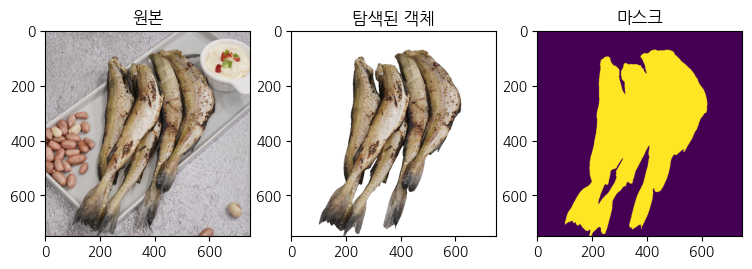

In [7]:
image_png = load_image("image01.png").convert("RGB")

if "segmenter" in globals():
    del segmenter
    segmenter = None
    segmenter = SegmentationModel()
flush_gpu()

sm_result, sm_mask = segmenter.run(image_png)
# 저장
sm_result.save(r"outputs/image01_result.png")
sm_mask.save(r"outputs/image01_mask.png")

plt.figure(figsize=(9, 3))
ax1 = plt.subplot(1, 3, 1)
ax1.imshow(image_png)
ax1.set_title("원본")

ax1 = plt.subplot(1, 3, 2)
ax1.imshow(sm_result)
ax1.set_title("탐색된 객체")

ax2 = plt.subplot(1, 3, 3)
ax2.imshow(sm_mask)
ax2.set_title("마스크")
plt.show()


In [8]:
if "segmenter" in globals():
    del segmenter
    segmenter = None

# 강력한 GPU 메모리 정리
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()
if hasattr(torch.cuda, 'ipc_collect'):
    torch.cuda.ipc_collect()

flush_gpu()
logger.debug("GPU Free")

2026-01-16 13:13:24 D [ipykernel_launcher:14] - GPU Free


In [13]:

class FluxGenerator:
    """
    - L4 GPU (22GB)에서 약 12~14GB VRAM 점유
    - txt2img, img2img, inpainting 파이프라인 지원
    """

    def __init__(self):
        self.model_id = MODEL_IDS["FLUX_4BIT"]
        
        self.pipe_txt2img = None
        self.pipe_img2img = None
        self.pipe_inpaint = None
        self.current_pipeline = None  # 현재 로드된 파이프라인 추적
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        logger.info(f"FluxGenerator initialized using: {self.model_id}")

    def _flush_gpu(self):
        flush_gpu()
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    def _unload_pipeline(self, pipeline_name: str):
        """특정 파이프라인을 메모리에서 언로드"""
        if pipeline_name == "txt2img" and self.pipe_txt2img is not None:
            logger.info("Unloading txt2img pipeline")
            del self.pipe_txt2img
            self.pipe_txt2img = None
        elif pipeline_name == "img2img" and self.pipe_img2img is not None:
            logger.info("Unloading img2img pipeline")
            del self.pipe_img2img
            self.pipe_img2img = None
        elif pipeline_name == "inpaint" and self.pipe_inpaint is not None:
            logger.info("Unloading inpaint pipeline")
            del self.pipe_inpaint
            self.pipe_inpaint = None
        self._flush_gpu()
    
    def unload_all_pipelines(self):
        """모든 파이프라인을 메모리에서 언로드 (외부 모델 로드 전 호출)"""
        logger.info("Unloading all pipelines to free GPU memory")
        if self.pipe_txt2img is not None:
            del self.pipe_txt2img
            self.pipe_txt2img = None
        if self.pipe_img2img is not None:
            del self.pipe_img2img
            self.pipe_img2img = None
        if self.pipe_inpaint is not None:
            del self.pipe_inpaint
            self.pipe_inpaint = None
        self.current_pipeline = None
        self._flush_gpu()
        logger.info("All pipelines unloaded")

    def _load_txt2img_pipeline(self):
        if self.pipe_txt2img is not None:
            return self.pipe_txt2img

        # 다른 파이프라인이 로드되어 있으면 언로드
        if self.current_pipeline not in [None, "txt2img"]:
            logger.info(f"Switching from {self.current_pipeline} to txt2img")
            self._unload_pipeline(self.current_pipeline)

        logger.info(f"Loading Quantized Pipeline from {self.model_id}...")
        self._flush_gpu()
        
        # 파이프라인 로드
        self.pipe_txt2img = DiffusionPipeline.from_pretrained(
            self.model_id,
            torch_dtype=TORCH_DTYPE,
        )
        
        # CPU 오프로드로 메모리 절약
        self.pipe_txt2img.enable_model_cpu_offload()
        
        self.current_pipeline = "txt2img"
        logger.info("Pipeline loaded with CPU offload (Memory Optimized Mode)")
        return self.pipe_txt2img

    def _load_img2img_pipeline(self):
        """img2img 파이프라인 로드"""
        if self.pipe_img2img is not None:
            return self.pipe_img2img

        # 다른 파이프라인이 로드되어 있으면 언로드
        if self.current_pipeline not in [None, "img2img"]:
            logger.info(f"Switching from {self.current_pipeline} to img2img")
            self._unload_pipeline(self.current_pipeline)

        logger.info(f"Loading Img2Img Pipeline from {self.model_id}...")
        self._flush_gpu()
        
        from diffusers import FluxImg2ImgPipeline
        
        self.pipe_img2img = FluxImg2ImgPipeline.from_pretrained(
            self.model_id,
            torch_dtype=TORCH_DTYPE,
        )
        
        # CPU 오프로드로 메모리 절약
        self.pipe_img2img.enable_model_cpu_offload()
        
        self.current_pipeline = "img2img"
        logger.info("Img2Img Pipeline loaded with CPU offload")
        return self.pipe_img2img

    def _load_inpaint_pipeline(self):
        """Inpainting 파이프라인 로드 - txt2img 파이프라인에서 변환"""
        if self.pipe_inpaint is not None:
            return self.pipe_inpaint

        logger.info("Loading Inpainting Pipeline...")
        
        # txt2img 파이프라인이 이미 로드되어 있으면 재사용
        if self.pipe_txt2img is not None:
            logger.info("Converting txt2img pipeline to inpaint pipeline (memory efficient)")
            self._flush_gpu()
            
            # txt2img 파이프라인의 컴포넌트를 재사용하여 inpaint 파이프라인 생성
            from diffusers import FluxInpaintPipeline
            
            self.pipe_inpaint = FluxInpaintPipeline(
                scheduler=self.pipe_txt2img.scheduler,
                text_encoder=self.pipe_txt2img.text_encoder,
                text_encoder_2=self.pipe_txt2img.text_encoder_2,
                tokenizer=self.pipe_txt2img.tokenizer,
                tokenizer_2=self.pipe_txt2img.tokenizer_2,
                transformer=self.pipe_txt2img.transformer,
                vae=self.pipe_txt2img.vae,
            )
            
            # txt2img 파이프라인 언로드
            del self.pipe_txt2img
            self.pipe_txt2img = None
            self._flush_gpu()
            
            # CPU 오프로드 활성화
            self.pipe_inpaint.enable_model_cpu_offload()
            
        else:
            # txt2img가 없으면 새로 로드
            if self.current_pipeline not in [None, "inpaint"]:
                logger.info(f"Switching from {self.current_pipeline} to inpaint")
                self._unload_pipeline(self.current_pipeline)
            
            self._flush_gpu()
            
            self.pipe_inpaint = FluxInpaintPipeline.from_pretrained(
                self.model_id,
                torch_dtype=TORCH_DTYPE,
            )
            
            # CPU 오프로드로 메모리 절약
            self.pipe_inpaint.enable_model_cpu_offload()
        
        self.current_pipeline = "inpaint"
        logger.info("Inpainting Pipeline loaded with CPU offload (Memory Optimized)")
        return self.pipe_inpaint

    def generate_background_and_compose_image(
        self,
        prompt: str,
        input_image: Optional[Image.Image] = None,
        width: int = 1024,
        height: int = 1024,
        num_inference_steps: int = 25,
        guidance_scale: float = 3.5,
        seed: int = None,
        **kwargs
    ) -> Image.Image:
        """
        txt2img 생성 (기존 메서드)
        """
        # 시드 설정
        generator = None
        if seed is not None:
            generator = torch.Generator(device="cpu").manual_seed(seed)
        
        logger.info(f"Generating image... Prompt: {prompt[:50]}")
        
        # 파이프라인 로드
        pipe = self._load_txt2img_pipeline() 
        self._flush_gpu()

        # 추론 실행
        with torch.no_grad():
            result = pipe(
                prompt=prompt,
                width=width,
                height=height,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                generator=generator,
                max_sequence_length=512
            )
        
        image = result.images[0]
        self._flush_gpu()
        return image

    def generate_img2img_from_segmented(
        self,
        prompt: str,
        product_foreground: Image.Image,
        product_mask: Image.Image,
        position: str = "center",
        scale: float = 0.4,
        width: int = 1024,
        height: int = 1024,
        num_inference_steps: int = 25,
        guidance_scale: float = 3.5,
        inpaint_strength: float = 0.5,
        use_inpainting: bool = True,
        seed: int = None,
        **kwargs
    ) -> Image.Image:
        """
        사전 세그멘테이션된 상품 이미지로 배경 합성
        
        프로세스:
        1. 배경 생성: prompt로 배경 이미지 생성 (txt2img)
        2. 상품 배치: 배경에 상품을 배치 (alpha composite)
        3. Inpainting: 배경과 자연스럽게 통합 (선택적)
        
        Args:
            prompt: 배경 생성 프롬프트
            product_foreground: 세그멘테이션된 상품 이미지 (RGBA, 알파 채널 포함)
            product_mask: 상품 마스크 (L 모드)
            position: 상품 배치 위치 ("center" | "bottom" | (x, y) 튜플)
            scale: 상품 크기 스케일 (0.3~0.6 권장, 기본값 0.4)
            width, height: 출력 해상도
            num_inference_steps: 배경 생성 샘플링 스텝 수
            guidance_scale: 가이던스 스케일
            inpaint_strength: Inpainting 강도 (0.3~0.7 권장, 기본값 0.5)
            use_inpainting: Inpainting 사용 여부 (True: 자연스러움, False: 빠름)
            seed: 랜덤 시드 (재현성)
            
        Returns:
            배경과 상품이 합성된 최종 이미지 (PIL.Image)
        """
        logger.info(f"Generating background with pre-segmented product: prompt='{prompt[:50]}...', scale={scale}, use_inpainting={use_inpainting}")
        
        # RGBA 검증
        if product_foreground.mode != "RGBA":
            raise ValueError(f"product_foreground must be RGBA format, got {product_foreground.mode}")
        
        # 1. 배경 생성 (txt2img)
        logger.info("Step 1/3: Generating background from prompt")
        background = self.generate_background_and_compose_image(
            prompt=prompt,
            width=width,
            height=height,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            seed=seed
        )
        logger.info(f"Background generated: size={background.size}")
        
        # 2. 상품 리사이즈 및 배치 계산
        logger.info("Step 2/3: Compositing product onto background")
        bg_w, bg_h = background.size
        
        # 상품 리사이즈 (scale 적용)
        fg_resized = product_foreground.resize(
            (int(product_foreground.width * scale), int(product_foreground.height * scale)),
            Image.LANCZOS
        )
        mask_resized = product_mask.convert("L").resize(fg_resized.size, Image.LANCZOS)
        
        # 배치 위치 계산
        if isinstance(position, str):
            if position == "center":
                x = (bg_w - fg_resized.width) // 2
                y = (bg_h - fg_resized.height) // 2
            elif position == "bottom":
                x = (bg_w - fg_resized.width) // 2
                y = int(bg_h * 0.6)  # 하단 60% 위치
            else:
                raise ValueError(f"Invalid position: {position}. Use 'center', 'bottom', or (x, y) tuple")
        else:
            x, y = position
        
        logger.info(f"Product placement: position=({x}, {y}), size={fg_resized.size}")
        
        # 3. Alpha Composite (초안 합성)
        draft = background.copy().convert("RGBA")
        draft.paste(fg_resized, (x, y), fg_resized)
        draft_rgb = draft.convert("RGB")
        
        # 4. Inpainting으로 자연스럽게 통합 (선택적)
        if use_inpainting:
            logger.info(f"Step 3/3: Applying Inpainting for natural blending (strength={inpaint_strength})")
            
            # 전체 크기 마스크 생성
            full_mask = Image.new("L", (bg_w, bg_h), 0)
            full_mask.paste(mask_resized, (x, y))
            
            # Inpainting 파이프라인 로드
            pipe = self._load_inpaint_pipeline()
            self._flush_gpu()
            
            # Generator 설정
            generator = None
            if seed is not None:
                generator = torch.Generator(device="cpu").manual_seed(seed)
            
            # Inpainting 실행
            with torch.no_grad():
                result = pipe(
                    prompt=prompt,
                    image=draft_rgb,
                    mask_image=full_mask,
                    strength=inpaint_strength,
                    guidance_scale=guidance_scale,
                    num_inference_steps=28,  # Inpainting은 28 steps 권장
                    generator=generator,
                ).images[0]
            
            self._flush_gpu()
            logger.info("Inpainting composition completed successfully")
            return result
        else:
            logger.info("Step 3/3: Skipping Inpainting (simple composite)")
            self._flush_gpu()
            logger.info("Simple composition completed successfully")
            return draft_rgb

    def generate_img2img(
        self,
        prompt: str,
        input_image: Image.Image,
        position: str = "center",
        scale: float = 0.4,
        width: int = 1024,
        height: int = 1024,
        num_inference_steps: int = 25,
        guidance_scale: float = 3.5,
        inpaint_strength: float = 0.5,
        use_inpainting: bool = True,
        seed: int = None,
        **kwargs
    ) -> Image.Image:
        """
        배경 생성 + 세그멘테이션 + 상품 합성 파이프라인
        
        프로세스:
        - RGB 입력: 세그멘테이션 수행 후 배경 합성 (메모리 집약적, OOM 위험)
        - RGBA 입력: 사전 세그멘테이션된 이미지로 간주하여 바로 배경 합성 (권장)
        
        Args:
            prompt: 배경 생성 프롬프트
            input_image: 상품 이미지 (RGB: 원본 / RGBA: 사전 세그멘테이션)
            position: 상품 배치 위치 ("center" | "bottom" | (x, y) 튜플)
            scale: 상품 크기 스케일 (0.3~0.6 권장, 기본값 0.4)
            width, height: 출력 해상도
            num_inference_steps: 배경 생성 샘플링 스텝 수
            guidance_scale: 가이던스 스케일
            inpaint_strength: Inpainting 강도 (0.3~0.7 권장)
            use_inpainting: Inpainting 사용 여부
            seed: 랜덤 시드 (재현성)
            
        Returns:
            배경과 상품이 합성된 최종 이미지 (PIL.Image)
        """
        # 타입 체크: RGBA면 사전 세그멘테이션으로 간주
        if input_image.mode == "RGBA":
            logger.info("Detected RGBA input - using pre-segmented workflow")
            # RGBA 입력의 경우 마스크 추출
            alpha_channel = input_image.split()[-1]
            return self.generate_img2img_from_segmented(
                prompt=prompt,
                product_foreground=input_image,
                product_mask=alpha_channel,
                position=position,
                scale=scale,
                width=width,
                height=height,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                inpaint_strength=inpaint_strength,
                use_inpainting=use_inpainting,
                seed=seed,
                **kwargs
            )
        
        # RGB 입력: 세그멘테이션 수행 (메모리 위험)
        logger.warning("RGB input detected - performing segmentation (OOM risk on low VRAM)")
        logger.info(f"Starting product composition pipeline: prompt='{prompt[:50]}...', scale={scale}")
        
        # 1. 세그멘테이션 (상품 분리)
        logger.info("Step 1/4: Segmentation - Extracting product from input image")
        segmenter = SegmentationModel()
        self._flush_gpu()
        
        product_fg, product_mask = segmenter.run(input_image)
        logger.info(f"Product extracted: size={product_fg.size}, mode={product_fg.mode}")
        
        # 세그멘테이션 모델 언로드
        del segmenter
        self._flush_gpu()
        
        # 2. 사전 세그멘테이션 워크플로우로 위임
        return self.generate_img2img_from_segmented(
            prompt=prompt,
            product_foreground=product_fg,
            product_mask=product_mask,
            position=position,
            scale=scale,
            width=width,
            height=height,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            inpaint_strength=inpaint_strength,
            use_inpainting=use_inpainting,
            seed=seed,
            **kwargs
        )

flux_generator = FluxGenerator()


2026-01-16 13:23:33 I [ipykernel_launcher:15] - FluxGenerator initialized using: diffusers/FLUX.1-dev-bnb-4bit


2026-01-16 13:23:44 I [ipykernel_launcher:9] - Step 0: Unload FluxGenerator to free memory for segmentation


2026-01-16 13:23:44 I [ipykernel_launcher:41] - Unloading all pipelines to free GPU memory
2026-01-16 13:23:48 I [ipykernel_launcher:53] - All pipelines unloaded
2026-01-16 13:23:48 I [ipykernel_launcher:13] - Step 1: Pre-segmentation
2026-01-16 13:23:48 D [ipykernel_launcher:29] - [Engine] Loading BiRefNet... (BiRefNet 모델 로딩 중)
2026-01-16 13:23:48 I [ipykernel_launcher:53] - All pipelines unloaded
2026-01-16 13:23:48 I [ipykernel_launcher:13] - Step 1: Pre-segmentation
2026-01-16 13:23:48 D [ipykernel_launcher:29] - [Engine] Loading BiRefNet... (BiRefNet 모델 로딩 중)
2026-01-16 13:23:52 I [ipykernel_launcher:18] - Segmentation completed, GPU memory released
2026-01-16 13:23:52 I [ipykernel_launcher:21] - Step 2: Background generation and composition
2026-01-16 13:23:52 I [ipykernel_launcher:367] - Detected RGBA input - using pre-segmented workflow
2026-01-16 13:23:52 I [ipykernel_launcher:241] - Generating background with pre-segmented product: prompt='A rustic wooden table surface with s

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2026-01-16 13:25:29 I [ipykernel_launcher:77] - Pipeline loaded with CPU offload (Memory Optimized Mode)


  0%|          | 0/25 [00:00<?, ?it/s]

2026-01-16 13:26:54 I [ipykernel_launcher:257] - Background generated: size=(1024, 1024)
2026-01-16 13:26:54 I [ipykernel_launcher:260] - Step 2/3: Compositing product onto background
2026-01-16 13:26:54 I [ipykernel_launcher:260] - Step 2/3: Compositing product onto background
2026-01-16 13:26:55 I [ipykernel_launcher:283] - Product placement: position=(343, 614), size=(337, 337)
2026-01-16 13:26:55 I [ipykernel_launcher:292] - Step 3/3: Applying Inpainting for natural blending (strength=0.5)
2026-01-16 13:26:55 I [ipykernel_launcher:112] - Loading Inpainting Pipeline...
2026-01-16 13:26:55 I [ipykernel_launcher:283] - Product placement: position=(343, 614), size=(337, 337)
2026-01-16 13:26:55 I [ipykernel_launcher:292] - Step 3/3: Applying Inpainting for natural blending (strength=0.5)
2026-01-16 13:26:55 I [ipykernel_launcher:112] - Loading Inpainting Pipeline...
2026-01-16 13:26:55 I [ipykernel_launcher:116] - Converting txt2img pipeline to inpaint pipeline (memory efficient)
2026-

  0%|          | 0/14 [00:00<?, ?it/s]

2026-01-16 13:27:39 I [ipykernel_launcher:320] - Inpainting composition completed successfully


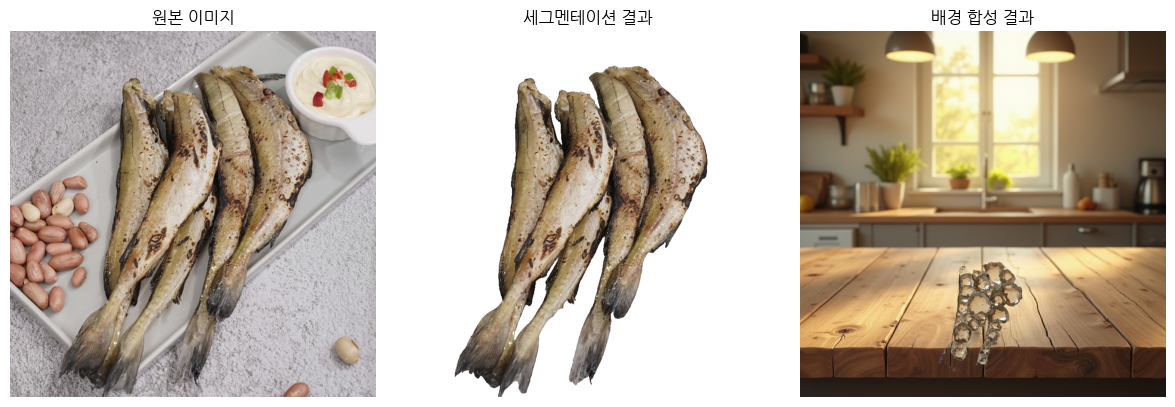

In [ ]:
import matplotlib.pyplot as plt

# 테스트 1: 메모리 최적화 워크플로우 (사전 세그멘테이션 + 배경 합성)
bg_prompt = """A rustic wooden table surface with soft natural lighting from the side, 
bokeh background of a sunlit kitchen, warm color tones, realistic textures, 
ultra-detailed 8K product photography background"""

# Step 1: 세그멘테이션 전 FluxGenerator 메모리 해제
logger.info("Step 0: Unload FluxGenerator to free memory for segmentation")
flux_generator.unload_all_pipelines()

# Step 2: 세그멘테이션 (독립 실행)
logger.info("Step 1: Pre-segmentation")
segmenter = SegmentationModel()
product_fg, product_mask = segmenter.run(image_png)
del segmenter
flush_gpu()
logger.info("Segmentation completed, GPU memory released")

# Step 3: 배경 생성 + 합성 (RGBA 입력 → 자동으로 generate_img2img_from_segmented 호출)
logger.info("Step 2: Background generation and composition")
ad_image = flux_generator.generate_img2img(
    prompt=bg_prompt,
    input_image=product_fg,  # RGBA 입력
    position="bottom",
    scale=0.45,
    width=1024,
    height=1024,
    num_inference_steps=25,
    guidance_scale=1.5,
    seed=42
)

plt.figure(figsize=(12, 4))
ax1 = plt.subplot(1, 3, 1)
ax1.imshow(image_png)
ax1.set_title("원본 이미지")
ax1.axis("off")

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(product_fg)
ax2.set_title("세그멘테이션 결과")
ax2.axis("off")

ax3 = plt.subplot(1, 3, 3)
ax3.imshow(ad_image)
ax3.set_title("배경 합성 결과")
ax3.axis("off")

plt.tight_layout()
plt.show()


2026-01-16 13:35:49 I [ipykernel_launcher:13] - Generating style 1/3: 고급 레스토랑
2026-01-16 13:35:49 I [ipykernel_launcher:367] - Detected RGBA input - using pre-segmented workflow
2026-01-16 13:35:49 I [ipykernel_launcher:241] - Generating background with pre-segmented product: prompt='Elegant restaurant table with white tablecloth, fi...', scale=0.4, use_inpainting=True
2026-01-16 13:35:49 I [ipykernel_launcher:248] - Step 1/3: Generating background from prompt
2026-01-16 13:35:49 I [ipykernel_launcher:179] - Generating image... Prompt: Elegant restaurant table with white tablecloth, fi
2026-01-16 13:35:49 I [ipykernel_launcher:367] - Detected RGBA input - using pre-segmented workflow
2026-01-16 13:35:49 I [ipykernel_launcher:241] - Generating background with pre-segmented product: prompt='Elegant restaurant table with white tablecloth, fi...', scale=0.4, use_inpainting=True
2026-01-16 13:35:49 I [ipykernel_launcher:248] - Step 1/3: Generating background from prompt
2026-01-16 13:35:49 

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2026-01-16 13:39:50 I [ipykernel_launcher:77] - Pipeline loaded with CPU offload (Memory Optimized Mode)


  0%|          | 0/20 [00:00<?, ?it/s]

2026-01-16 13:41:22 I [ipykernel_launcher:257] - Background generated: size=(1024, 1024)
2026-01-16 13:41:22 I [ipykernel_launcher:260] - Step 2/3: Compositing product onto background
2026-01-16 13:41:22 I [ipykernel_launcher:260] - Step 2/3: Compositing product onto background
2026-01-16 13:41:22 I [ipykernel_launcher:283] - Product placement: position=(362, 362), size=(300, 300)
2026-01-16 13:41:22 I [ipykernel_launcher:292] - Step 3/3: Applying Inpainting for natural blending (strength=0.5)
2026-01-16 13:41:22 I [ipykernel_launcher:283] - Product placement: position=(362, 362), size=(300, 300)
2026-01-16 13:41:22 I [ipykernel_launcher:292] - Step 3/3: Applying Inpainting for natural blending (strength=0.5)
2026-01-16 13:41:22 I [ipykernel_launcher:112] - Loading Inpainting Pipeline...
2026-01-16 13:41:22 I [ipykernel_launcher:112] - Loading Inpainting Pipeline...
2026-01-16 13:41:22 I [ipykernel_launcher:116] - Converting txt2img pipeline to inpaint pipeline (memory efficient)
2026-

  0%|          | 0/14 [00:00<?, ?it/s]

2026-01-16 13:43:06 I [ipykernel_launcher:320] - Inpainting composition completed successfully
2026-01-16 13:43:06 I [ipykernel_launcher:13] - Generating style 2/3: 야외 바베큐
2026-01-16 13:43:06 I [ipykernel_launcher:13] - Generating style 2/3: 야외 바베큐
2026-01-16 13:43:06 I [ipykernel_launcher:367] - Detected RGBA input - using pre-segmented workflow
2026-01-16 13:43:06 I [ipykernel_launcher:241] - Generating background with pre-segmented product: prompt='Outdoor wooden picnic table, natural daylight, gar...', scale=0.4, use_inpainting=True
2026-01-16 13:43:06 I [ipykernel_launcher:248] - Step 1/3: Generating background from prompt
2026-01-16 13:43:06 I [ipykernel_launcher:179] - Generating image... Prompt: Outdoor wooden picnic table, natural daylight, gar
2026-01-16 13:43:06 I [ipykernel_launcher:61] - Switching from inpaint to txt2img
2026-01-16 13:43:06 I [ipykernel_launcher:34] - Unloading inpaint pipeline
2026-01-16 13:43:06 I [ipykernel_launcher:367] - Detected RGBA input - using pr

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2026-01-16 13:47:38 I [ipykernel_launcher:77] - Pipeline loaded with CPU offload (Memory Optimized Mode)


  0%|          | 0/20 [00:00<?, ?it/s]

2026-01-16 13:49:49 I [ipykernel_launcher:257] - Background generated: size=(1024, 1024)
2026-01-16 13:49:49 I [ipykernel_launcher:260] - Step 2/3: Compositing product onto background
2026-01-16 13:49:49 I [ipykernel_launcher:283] - Product placement: position=(362, 362), size=(300, 300)
2026-01-16 13:49:49 I [ipykernel_launcher:292] - Step 3/3: Applying Inpainting for natural blending (strength=0.5)
2026-01-16 13:49:49 I [ipykernel_launcher:112] - Loading Inpainting Pipeline...
2026-01-16 13:49:49 I [ipykernel_launcher:116] - Converting txt2img pipeline to inpaint pipeline (memory efficient)
2026-01-16 13:49:51 I [ipykernel_launcher:157] - Inpainting Pipeline loaded with CPU offload (Memory Optimized)


  0%|          | 0/14 [00:00<?, ?it/s]

2026-01-16 13:51:36 I [ipykernel_launcher:320] - Inpainting composition completed successfully
2026-01-16 13:51:36 I [ipykernel_launcher:13] - Generating style 3/3: 현대적 주방
2026-01-16 13:51:36 I [ipykernel_launcher:367] - Detected RGBA input - using pre-segmented workflow
2026-01-16 13:51:36 I [ipykernel_launcher:241] - Generating background with pre-segmented product: prompt='Modern minimalist kitchen countertop, marble surfa...', scale=0.4, use_inpainting=True
2026-01-16 13:51:36 I [ipykernel_launcher:248] - Step 1/3: Generating background from prompt
2026-01-16 13:51:36 I [ipykernel_launcher:179] - Generating image... Prompt: Modern minimalist kitchen countertop, marble surfa
2026-01-16 13:51:36 I [ipykernel_launcher:61] - Switching from inpaint to txt2img
2026-01-16 13:51:36 I [ipykernel_launcher:34] - Unloading inpaint pipeline
2026-01-16 13:51:40 I [ipykernel_launcher:64] - Loading Quantized Pipeline from diffusers/FLUX.1-dev-bnb-4bit...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2026-01-16 13:56:07 I [ipykernel_launcher:77] - Pipeline loaded with CPU offload (Memory Optimized Mode)


  0%|          | 0/20 [00:00<?, ?it/s]

2026-01-16 13:57:49 I [ipykernel_launcher:257] - Background generated: size=(1024, 1024)
2026-01-16 13:57:49 I [ipykernel_launcher:260] - Step 2/3: Compositing product onto background
2026-01-16 13:57:50 I [ipykernel_launcher:283] - Product placement: position=(362, 362), size=(300, 300)
2026-01-16 13:57:50 I [ipykernel_launcher:292] - Step 3/3: Applying Inpainting for natural blending (strength=0.5)
2026-01-16 13:57:50 I [ipykernel_launcher:112] - Loading Inpainting Pipeline...
2026-01-16 13:57:50 I [ipykernel_launcher:116] - Converting txt2img pipeline to inpaint pipeline (memory efficient)
2026-01-16 13:57:51 I [ipykernel_launcher:157] - Inpainting Pipeline loaded with CPU offload (Memory Optimized)


  0%|          | 0/14 [00:00<?, ?it/s]

2026-01-16 13:59:05 I [ipykernel_launcher:320] - Inpainting composition completed successfully


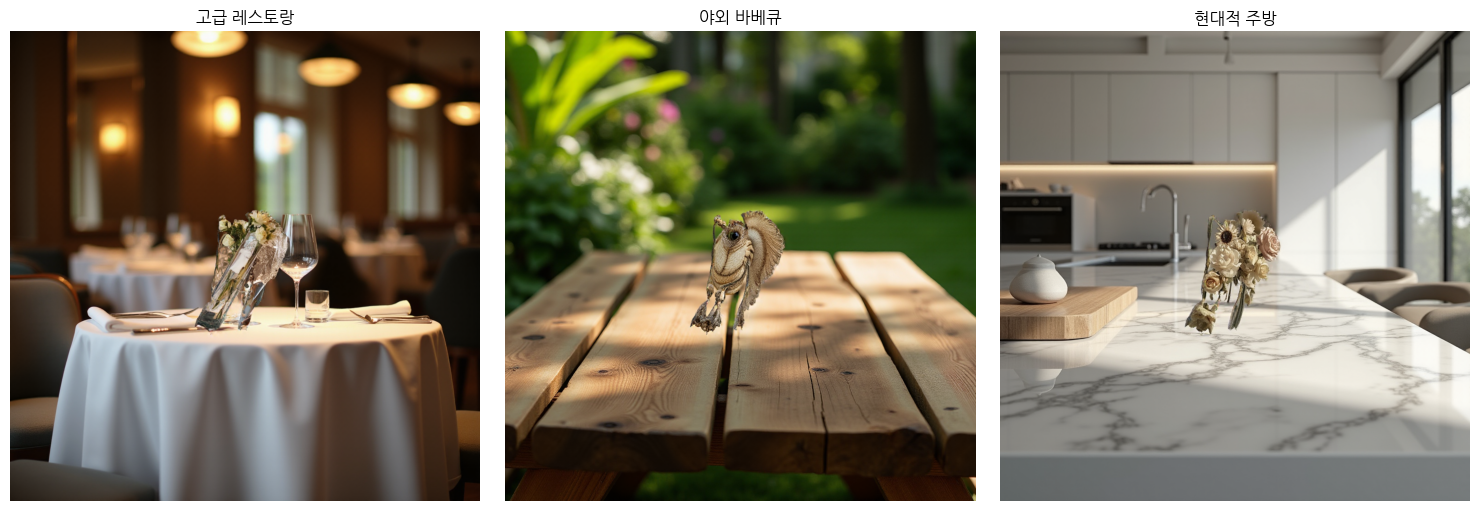

In [15]:
# 테스트 2: 다양한 배경 스타일 테스트 (메모리 최적화)

test_prompts = [
    ("고급 레스토랑", "Elegant restaurant table with white tablecloth, fine dining atmosphere, soft ambient lighting, blurred background, luxury setting"),
    ("야외 바베큐", "Outdoor wooden picnic table, natural daylight, garden background with green plants, summer vibes, rustic outdoor setting"),
    ("현대적 주방", "Modern minimalist kitchen countertop, marble surface, bright natural light, clean contemporary style, sharp focus on surface")
]

# 사전 세그멘테이션 재사용 (이미 product_fg가 메모리에 있음)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (title, prompt) in enumerate(test_prompts):
    logger.info(f"Generating style {idx+1}/3: {title}")
    
    result = flux_generator.generate_img2img(
        prompt=prompt,
        input_image=product_fg,  # RGBA 입력 (사전 세그멘테이션)
        position="center",
        scale=0.4,
        width=1024,
        height=1024,
        num_inference_steps=20,
        guidance_scale=3.5,
        seed=42 + idx
    )
    
    axes[idx].imshow(result)
    axes[idx].set_title(title)
    axes[idx].axis("off")
    
    flush_gpu()

plt.tight_layout()
plt.show()


2026-01-16 13:59:14 I [ipykernel_launcher:7] - Testing Inpainting with strength=0.3
2026-01-16 13:59:14 I [ipykernel_launcher:367] - Detected RGBA input - using pre-segmented workflow
2026-01-16 13:59:14 I [ipykernel_launcher:241] - Generating background with pre-segmented product: prompt='A rustic wooden table surface with soft natural li...', scale=0.45, use_inpainting=True
2026-01-16 13:59:14 I [ipykernel_launcher:248] - Step 1/3: Generating background from prompt
2026-01-16 13:59:14 I [ipykernel_launcher:179] - Generating image... Prompt: A rustic wooden table surface with soft natural li
2026-01-16 13:59:14 I [ipykernel_launcher:61] - Switching from inpaint to txt2img
2026-01-16 13:59:14 I [ipykernel_launcher:34] - Unloading inpaint pipeline
2026-01-16 13:59:18 I [ipykernel_launcher:64] - Loading Quantized Pipeline from diffusers/FLUX.1-dev-bnb-4bit...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2026-01-16 14:03:42 I [ipykernel_launcher:77] - Pipeline loaded with CPU offload (Memory Optimized Mode)


  0%|          | 0/25 [00:00<?, ?it/s]

2026-01-16 14:05:25 I [ipykernel_launcher:257] - Background generated: size=(1024, 1024)
2026-01-16 14:05:25 I [ipykernel_launcher:260] - Step 2/3: Compositing product onto background
2026-01-16 14:05:25 I [ipykernel_launcher:283] - Product placement: position=(343, 614), size=(337, 337)
2026-01-16 14:05:25 I [ipykernel_launcher:292] - Step 3/3: Applying Inpainting for natural blending (strength=0.3)
2026-01-16 14:05:25 I [ipykernel_launcher:112] - Loading Inpainting Pipeline...
2026-01-16 14:05:25 I [ipykernel_launcher:116] - Converting txt2img pipeline to inpaint pipeline (memory efficient)
2026-01-16 14:05:27 I [ipykernel_launcher:157] - Inpainting Pipeline loaded with CPU offload (Memory Optimized)


  0%|          | 0/9 [00:00<?, ?it/s]

2026-01-16 14:07:09 I [ipykernel_launcher:320] - Inpainting composition completed successfully
2026-01-16 14:07:09 I [ipykernel_launcher:7] - Testing Inpainting with strength=0.5
2026-01-16 14:07:09 I [ipykernel_launcher:367] - Detected RGBA input - using pre-segmented workflow
2026-01-16 14:07:09 I [ipykernel_launcher:241] - Generating background with pre-segmented product: prompt='A rustic wooden table surface with soft natural li...', scale=0.45, use_inpainting=True
2026-01-16 14:07:09 I [ipykernel_launcher:248] - Step 1/3: Generating background from prompt
2026-01-16 14:07:09 I [ipykernel_launcher:179] - Generating image... Prompt: A rustic wooden table surface with soft natural li
2026-01-16 14:07:09 I [ipykernel_launcher:61] - Switching from inpaint to txt2img
2026-01-16 14:07:09 I [ipykernel_launcher:34] - Unloading inpaint pipeline
2026-01-16 14:07:13 I [ipykernel_launcher:64] - Loading Quantized Pipeline from diffusers/FLUX.1-dev-bnb-4bit...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2026-01-16 14:11:18 I [ipykernel_launcher:77] - Pipeline loaded with CPU offload (Memory Optimized Mode)


  0%|          | 0/25 [00:00<?, ?it/s]

2026-01-16 14:13:00 I [ipykernel_launcher:257] - Background generated: size=(1024, 1024)
2026-01-16 14:13:00 I [ipykernel_launcher:260] - Step 2/3: Compositing product onto background
2026-01-16 14:13:00 I [ipykernel_launcher:283] - Product placement: position=(343, 614), size=(337, 337)
2026-01-16 14:13:00 I [ipykernel_launcher:292] - Step 3/3: Applying Inpainting for natural blending (strength=0.5)
2026-01-16 14:13:00 I [ipykernel_launcher:112] - Loading Inpainting Pipeline...
2026-01-16 14:13:00 I [ipykernel_launcher:116] - Converting txt2img pipeline to inpaint pipeline (memory efficient)
2026-01-16 14:13:02 I [ipykernel_launcher:157] - Inpainting Pipeline loaded with CPU offload (Memory Optimized)


  0%|          | 0/14 [00:00<?, ?it/s]

2026-01-16 14:14:41 I [ipykernel_launcher:320] - Inpainting composition completed successfully
2026-01-16 14:14:41 I [ipykernel_launcher:7] - Testing Inpainting with strength=0.7
2026-01-16 14:14:41 I [ipykernel_launcher:367] - Detected RGBA input - using pre-segmented workflow
2026-01-16 14:14:41 I [ipykernel_launcher:241] - Generating background with pre-segmented product: prompt='A rustic wooden table surface with soft natural li...', scale=0.45, use_inpainting=True
2026-01-16 14:14:41 I [ipykernel_launcher:248] - Step 1/3: Generating background from prompt
2026-01-16 14:14:41 I [ipykernel_launcher:179] - Generating image... Prompt: A rustic wooden table surface with soft natural li
2026-01-16 14:14:41 I [ipykernel_launcher:61] - Switching from inpaint to txt2img
2026-01-16 14:14:41 I [ipykernel_launcher:34] - Unloading inpaint pipeline
2026-01-16 14:14:45 I [ipykernel_launcher:64] - Loading Quantized Pipeline from diffusers/FLUX.1-dev-bnb-4bit...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2026-01-16 14:19:11 I [ipykernel_launcher:77] - Pipeline loaded with CPU offload (Memory Optimized Mode)


  0%|          | 0/25 [00:00<?, ?it/s]

2026-01-16 14:21:02 I [ipykernel_launcher:257] - Background generated: size=(1024, 1024)
2026-01-16 14:21:02 I [ipykernel_launcher:260] - Step 2/3: Compositing product onto background
2026-01-16 14:21:02 I [ipykernel_launcher:283] - Product placement: position=(343, 614), size=(337, 337)
2026-01-16 14:21:02 I [ipykernel_launcher:292] - Step 3/3: Applying Inpainting for natural blending (strength=0.7)
2026-01-16 14:21:02 I [ipykernel_launcher:112] - Loading Inpainting Pipeline...
2026-01-16 14:21:02 I [ipykernel_launcher:116] - Converting txt2img pipeline to inpaint pipeline (memory efficient)
2026-01-16 14:21:04 I [ipykernel_launcher:157] - Inpainting Pipeline loaded with CPU offload (Memory Optimized)


  0%|          | 0/20 [00:00<?, ?it/s]

2026-01-16 14:22:46 I [ipykernel_launcher:320] - Inpainting composition completed successfully


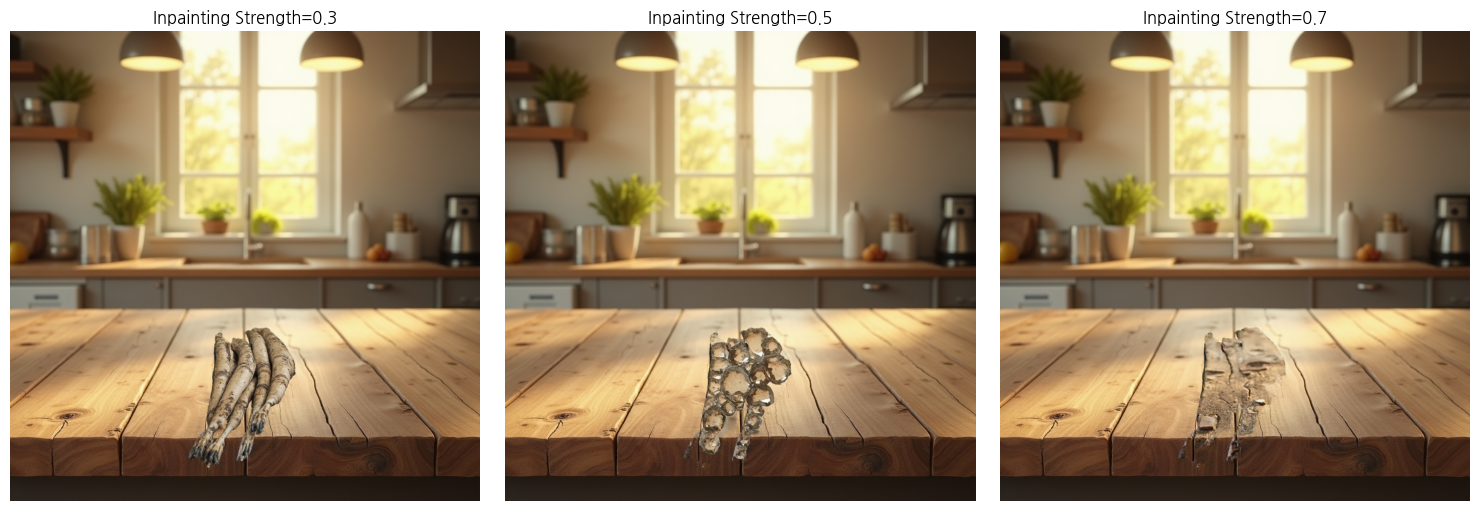

2026-01-16 14:22:48 I [ipykernel_launcher:37] - 
Inpainting Strength 가이드:
- 0.3: 원본 유지, 미세 조정 (자연스러움 낮음)
- 0.5: 균형 잡힌 통합 (권장)
- 0.7: 배경과 강하게 통합 (자연스러움 높음, 상품 변형 가능)



In [16]:
# 테스트 4: Inpainting Strength 비교 (0.3, 0.5, 0.7)

strengths = [0.3, 0.5, 0.7]
results = []

for strength in strengths:
    logger.info(f"Testing Inpainting with strength={strength}")
    
    result = flux_generator.generate_img2img(
        prompt=bg_prompt,
        input_image=product_fg,
        position="bottom",
        scale=0.45,
        width=1024,
        height=1024,
        num_inference_steps=25,
        guidance_scale=3.5,
        inpaint_strength=strength,
        use_inpainting=True,
        seed=42
    )
    
    results.append(result)
    flush_gpu()

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (strength, result) in enumerate(zip(strengths, results)):
    axes[idx].imshow(result)
    axes[idx].set_title(f"Inpainting Strength={strength}")
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

logger.info("""
Inpainting Strength 가이드:
- 0.3: 원본 유지, 미세 조정 (자연스러움 낮음)
- 0.5: 균형 잡힌 통합 (권장)
- 0.7: 배경과 강하게 통합 (자연스러움 높음, 상품 변형 가능)
""")

In [ ]:
# 테스트 3: Inpainting 비교 (단순 합성 vs Inpainting)

bg_prompt = """A rustic wooden table surface with soft natural lighting from the side, 
bokeh background of a sunlit kitchen, warm color tones, realistic textures, 
ultra-detailed 8K product photography background"""

# 단순 합성 (use_inpainting=False)
logger.info("Test 1: Simple composite (no inpainting)")
result_simple = flux_generator.generate_img2img(
    prompt=bg_prompt,
    input_image=product_fg,  # RGBA 입력
    position="bottom",
    scale=0.45,
    width=1024,
    height=1024,
    num_inference_steps=25,
    guidance_scale=3.5,
    use_inpainting=False,  # Inpainting 비활성화
    seed=42
)

flush_gpu()

# Inpainting 합성 (use_inpainting=True)
logger.info("Test 2: Inpainting composite (natural blending)")
result_inpaint = flux_generator.generate_img2img(
    prompt=bg_prompt,
    input_image=product_fg,  # RGBA 입력
    position="bottom",
    scale=0.45,
    width=1024,
    height=1024,
    num_inference_steps=25,
    guidance_scale=3.5,
    inpaint_strength=0.5,  # Inpainting 강도
    use_inpainting=True,   # Inpainting 활성화
    seed=42
)

# 비교 시각화
plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 3, 1)
ax1.imshow(image_png)
ax1.set_title("원본 이미지")
ax1.axis("off")

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(result_simple)
ax2.set_title("단순 합성 (Alpha Composite)")
ax2.axis("off")

ax3 = plt.subplot(1, 3, 3)
ax3.imshow(result_inpaint)
ax3.set_title("Inpainting 합성 (자연스러움)")
ax3.axis("off")

plt.tight_layout()
plt.show()

# 저장
result_simple.save("outputs/result_simple_composite.png")
result_inpaint.save("outputs/result_inpainting_composite.png")
logger.info("Results saved to outputs/")

2026-01-16 14:22:53 I [ipykernel_launcher:8] - Test 1: Simple composite (no inpainting)
2026-01-16 14:22:53 I [ipykernel_launcher:367] - Detected RGBA input - using pre-segmented workflow
2026-01-16 14:22:53 I [ipykernel_launcher:241] - Generating background with pre-segmented product: prompt='A rustic wooden table surface with soft natural li...', scale=0.45, use_inpainting=False
2026-01-16 14:22:53 I [ipykernel_launcher:248] - Step 1/3: Generating background from prompt
2026-01-16 14:22:53 I [ipykernel_launcher:179] - Generating image... Prompt: A rustic wooden table surface with soft natural li
2026-01-16 14:22:53 I [ipykernel_launcher:61] - Switching from inpaint to txt2img
2026-01-16 14:22:53 I [ipykernel_launcher:34] - Unloading inpaint pipeline
2026-01-16 14:22:57 I [ipykernel_launcher:64] - Loading Quantized Pipeline from diffusers/FLUX.1-dev-bnb-4bit...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]